# Download Data

### Use Google Drive to store the weights from Mask RCNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Remove any previous contents in the colab directory

In [2]:
rm -rf json/ labels/ images/ dataset.zip sample_data

### Download the image annotations from DeepGIS.

You can generate dataset by clicking the Deep Learning Zoo/Mask RCNN option (left side) of DeepGIS. This will create generate a link similar to 
https://project_name.deepgis.org/media/labels/harish/iKRvgHFmrWuDHppM/dataset.zip

Example shown here is that of LROC NAC image dataset, you can replace the dataset.zip with your annotations in DeepGIS

In [3]:
! wget https://fish.deepgis.org/media/labels/harish/BkFFradZLXxcWHhR/dataset.zip

--2020-12-07 21:21:10--  https://fish.deepgis.org/media/labels/harish/BkFFradZLXxcWHhR/dataset.zip
Resolving fish.deepgis.org (fish.deepgis.org)... 129.219.113.11
Connecting to fish.deepgis.org (fish.deepgis.org)|129.219.113.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26429863 (25M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  25.21M  1.61MB/s    in 16s     

2020-12-07 21:21:26 (1.59 MB/s) - ‘dataset.zip’ saved [26429863/26429863]



### Unzip the dataset.zip file. 
There will be two folders json/ and images/

In [4]:
! unzip -qq dataset.zip

# Import libraries

### Convert json to numpy masks

In [ ]:
! pip install wand
! apt-get install libmagickwand-dev -y -q

In [8]:
import os
import json
import re
import numpy as np
from wand.image import Image as WandImage
from wand.color import Color as WandColor
import io
import imageio
from bs4 import BeautifulSoup
import torch
from PIL import Image
import pickle
import cv2

In [9]:
def image_string_to_SVG_string_file(svgStr):
    SVG_string_file = io.StringIO(svgStr)
    SVG_string_file.seek(0)
    return SVG_string_file.read().encode('utf-8')

def image_label_string_to_SVG_string(DBStr, height=None, width=None, x=0, y=0, keepImage=False):
    addedStr = DBStr
    #get the image path
    imagePath = ""
    imageString = ""
    if keepImage:
        imagePath = re.search('ns1:href="(.*)png"', DBStr)
        try:
            imagePath = imagePath.group(1)+"png"
        except AttributeError as e:
            imagePath = re.search('a0:href="(.*)png"', DBStr)
            imagePath = imagePath.group(1) + "png"

        imageWidth = re.search(r'width="(\d+)"', addedStr).group(1)
        imageHeight = re.search(r'height="(\d+)"', addedStr).group(1)

        imageString = '<defs><pattern id="backgroundImage" ' \
        'patternUnits="userSpaceOnUse" width="%s" height="%s">' \
        '<image xlink:href="%s" x="-%s" y="-%s" width="%s" height="%s"/>' \
        '</pattern></defs><rect id="background" fill="url(#backgroundImage)" '\
        'width="%s" height="%s"/>' % (width, height, imagePath, x, y, imageWidth, imageHeight, width, height)

    if height == None or width == None:
        image, height, width = SVGDimensions(DBStr)
        if not keepImage and image:
            addedStr = DBStr.replace(image, '')

    addedStr = re.sub(r'<image.+hidden"/>', '', addedStr)
    addedStr = addedStr.encode('utf-8')
    return '<?xml version="1.0" encoding="UTF-8" standalone="no"?>' \
           '<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg"' \
           ' xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px" xml:space="preserve" height="%s"' \
           ' width="%s">%s%s</svg>' % (height, width, imageString, addedStr)


In [10]:
! rm -rf labels

In [11]:
IMAGE_FILE_EXTENSION = ".png"

CATEGORY_NAMES = None

json_files = os.listdir('json/')

if not os.path.exists('labels/'):
    os.makedirs('labels/')

for json_file in json_files:
  with open('json/' + json_file) as f:
    data = json.load(f)
  
  outputFilenameNpy = 'labels/' + json_file[:-4] + 'npy'
  height = data["height"]
  width = data["width"]
  ctr = 0
  total_paths = 600
  masks_ndarray = np.zeros((total_paths, height, width), dtype=np.int8)

  CATEGORY_NAMES = data["categories"]

  for id, element in data["labelShapes"]:
    category_id = id
    svg = element
    paths = []
    poly = []
    soup = BeautifulSoup(svg)
    circles = soup.find_all('circle')
    poly = soup.find_all('polygon')
    paths = soup.find_all('path')
    ellipse = soup.find_all('ellipse')
    shapes = paths + poly + circles + ellipse

    if len(paths) + len(poly) + len(circles) + len(ellipse) > 0:
      for idx,path in enumerate(shapes):
        img=WandImage(blob=image_string_to_SVG_string_file(image_label_string_to_SVG_string(str(path),height,width)))
        img.resize(width, height)
        img.background_color = WandColor('white')
        img.alpha_channel = 'remove'
        img.negate()
        img.threshold(0)
        img.format = 'png'

        outputFilename = ('labels/' + json_file[:-4] + 'png')

        img.save(filename=outputFilename)
        im = imageio.imread(outputFilename)

        masks = np.array(im)
        cat_mask = np.where(masks == 255, category_id , masks)

        if cat_mask.max() != 0:
          cat_mask_check = cat_mask > 0
          cat_mask_check = cat_mask_check.astype(np.uint8)
          pos = np.where(cat_mask_check)
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          if xmin < xmax and ymin < ymax:
            masks_ndarray[ctr, :, :] = cat_mask
            ctr = ctr + 1
          else:
            print("failed")
            # print(ctr)

  print(outputFilenameNpy)
  
  if ctr == 0:
    masks_ndarray[0, :, :] = np.zeros((height, width))
    print("NO MASKS FOUND")
    ctr = 1
  
  print(ctr)
  masks_ndarray.resize(ctr, height, width)
  masks_ndarray = masks_ndarray.transpose(1, 2, 0)

  np.save(outputFilenameNpy, masks_ndarray)

  for rmfile in os.listdir('labels/'):
      if rmfile.endswith('.png'):
          os.remove('labels/' + rmfile)    

labels/_static_fish_Alvin5008_down__12_12_2018_20-29-02_0_480.npy
1
labels/_static_fish_Alvin5008_down__12_12_2018_18-42-12_0_0.npy
90
labels/_static_fish_Alvin5008_down__12_12_2018_17-41-22_0_480.npy
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_18-33-02_0_0.npy
55
labels/_static_fish_Alvin5008_down__12_12_2018_18-05-42_0_480.npy
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_21-21-42_720_0.npy
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_0.npy
3
labels/_static_fish_Alvin5008_down__12_12_2018_21-35-02_0_0.npy
83
labels/_static_fish_Alvin5008_down__12_12_2018_20-50-12_0_0.npy
2
labels/_static_fish_Alvin5008_down__12_12_2018_18-33-02_0_480.npy
45
labels/_static_fish_Alvin5008_down__12_12_2018_19-12-22_0_0.npy
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_21-21-42_0_0.npy
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_19-49-02_0_0.npy
12
labels/_static_fish_Alvin5008_down__12_12_2018_18-05

### Display Annotations on one of the images

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

### Select a file and plot the masks


In [13]:
mask_files = os.listdir('labels/')
mask_file = 'labels/' + mask_files[0]

Opening mask file labels/_static_fish_Alvin5008_down__12_12_2018_21-27-52_0_480.npy


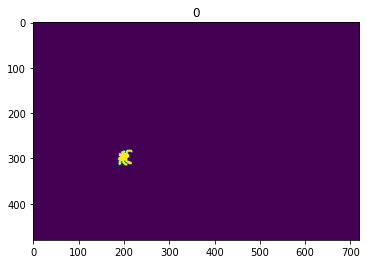

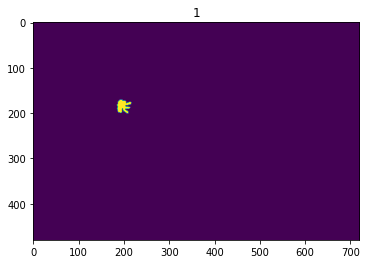

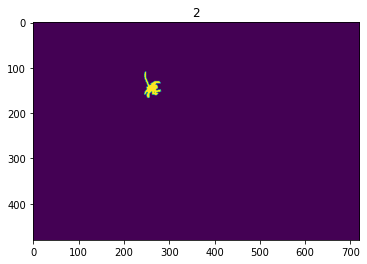

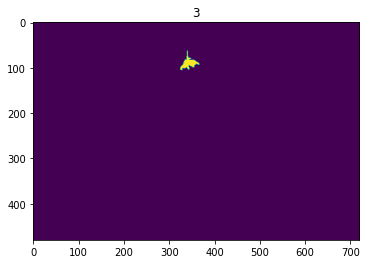

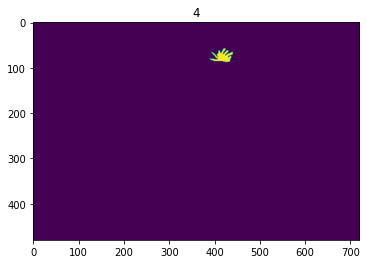

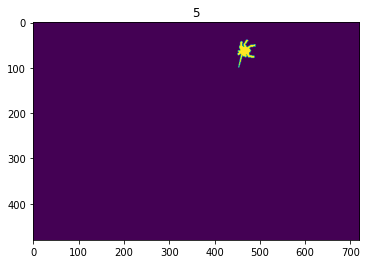

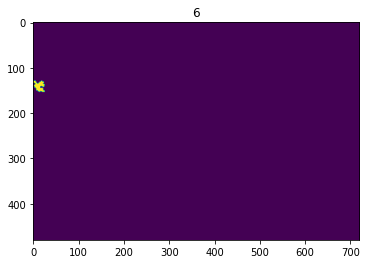

In [14]:
print("Opening mask file " + mask_file)

mask = np.load(mask_file)  

for i in range(mask.shape[2]):
  plt.figure()
  plt.imshow(mask[:, :,i])
  plt.title(str(i))

(480, 720, 7)


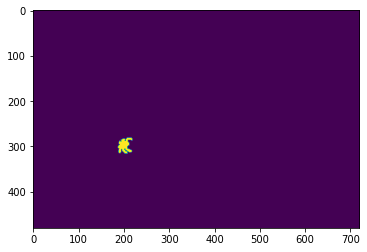

In [15]:
mask = np.load(mask_file)

print(mask.shape)

image = mask[:, :, 0]
plt.imshow(image)
plt.imsave('name.png', image)

### Overlay one of the image annotation on top of the image to validate the annotations

Image file is images/_static_fish_Alvin5008_down__12_12_2018_21-27-52_0_480.png


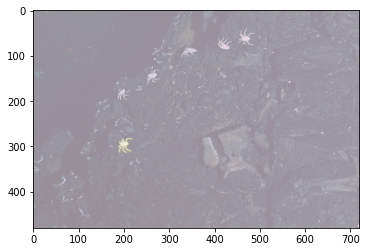

In [16]:
img = Image.open("name.png").convert("RGBA")
corresponding_image_file = "images/"  + mask_files[0].split(".")[0] + ".png"
print("Image file is " + corresponding_image_file)
background = Image.open(corresponding_image_file).convert("RGBA")

background.putalpha(64)
background.paste(img, (0, 0), background)
background.save('superimpose.png',"PNG")
img = mpimg.imread('superimpose.png')
imgplot = plt.imshow(img)

### Import libraries

In [17]:
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py 
! wget https://raw.githubusercontent.com/DREAMS-lab/mask_rcnn_pytorch/master/visualize.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py

--2020-12-07 21:23:29--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3699 (3.6K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.61K  --.-KB/s    in 0s      

2020-12-07 21:23:29 (73.2 MB/s) - ‘engine.py’ saved [3699/3699]

--2020-12-07 21:23:29--  https://raw.githubusercontent.com/DREAMS-lab/mask_rcnn_pytorch/master/visualize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15111 (15K) [text/plain]
Saving to:

In [36]:
from engine import train_one_epoch, evaluate
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

### Mask RCNN Dataset

In [37]:
class Dataset(object):
    def __init__(self, image_path, label_path, transforms=None, savePickle=True, readsave=True, include_name=True):
        self.image_path = image_path
        self.label_path = label_path
        self.transforms = transforms
        self.images = [f for f in os.listdir(image_path) if f.endswith(".png")]
        self.masks = [f for f in os.listdir(label_path) if f.endswith(".npy")]
        self.include_name = include_name
        self.savePickle = savePickle
        self.__refine(readsave)


    def __refine(self, readsave):
        if not readsave:
            images = []
            masks = []
            for img in self.images:
                frame = img[:-4]
                mask = frame + ".npy"
                if mask in self.masks:
                    mask_path = os.path.join(self.label_path, mask)
                    mask_nd = np.load(mask_path)
                    if mask_nd.max() > 0:
                        images.append(img)
                        masks.append(mask)

            self.images = images
            self.masks = masks
            data = {"images": images, "masks": masks,}
            if self.savePickle:
                with open('data.pickle', 'wb') as filehandle:
                    pickle.dump(data, filehandle)
        else:
            with open('data.pickle', 'rb') as filehandle:
                data = pickle.load(filehandle)
                self.images = data["images"]
                self.masks = data["masks"]


    def __getitem(self, idx):
        img_path = os.path.join(self.image_path, self.images[idx])
        mask_path = os.path.join(self.label_path, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        # In training, 0 is of background
        masks = np.load(mask_path)
        masks = masks > 0  # convert to binary masks
        masks = masks.astype(np.uint8)
        num_objs = masks.shape[2]
        obj_ids = np.ones(num_objs)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[:, :, i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        labels = torch.as_tensor(obj_ids, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        masks = masks.permute((2, 0, 1))

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.include_name:
            target["image_name"] = img_path

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __getitem__(self, idx):
        image, target = self.__getitem(idx)
        labels = target["labels"]
        #labels = labels + 1 # multiple classes
        #labels = (labels > 0).type(torch.int64) + 1  # only two classes, non-damaged and damaged
        target["labels"] = labels
        return image, target

    def __len__(self):
        return len(self.images)

    def display(self, idx):
        image, target = self.__getitem__(idx)
        #image = image.permute((1, 2, 0))
        #image = (image.numpy() * 255).astype(np.uint8)
        #image = Image.fromarray(image)
        image.show()

        masks = target["masks"]
        masks = masks.permute((1, 2, 0))
        masks = masks.numpy()
        masks = masks.max(axis=2) * 255
        masks = Image.fromarray(masks)
        masks.show()

    def imageStat(self):
        images = np.empty((0, 3), float)
        for data_file in self.images:
            data_path = os.path.join(self.image_path, data_file)
            data = cv2.imread(data_path)
            image = data.astype(float).reshape(-1, 3)/255.0
            images = np.append(images, image, axis=0)
        return np.mean(images, axis=0).tolist(), np.std(images, axis=0).tolist(), \
               np.max(images, axis=0).tolist(), np.min(images, axis=0).tolist()

# Define utils

In [38]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = np.array(image)
        image = torch.from_numpy(image / 255.0).float()
        image = image.permute((2, 0, 1))
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor()) 
    return Compose(transforms)

def get_mean_std(input_channel, image_mean, image_std):
    if input_channel == 8:
        return image_mean, image_std
    elif input_channel == 3:
        return image_mean[:3], image_std[:3]
    elif input_channel == 5:
        return image_mean[:5], image_std[:5]
    elif input_channel == 6:
        return image_mean[:3] + image_mean[-3:], image_std[:3] + image_mean[-3:]
    elif input_channel == 4:
        return image_mean[:3] + [np.mean(image_mean[-3:]).tolist()], image_std[:3] + [np.mean(image_std[-3:]).tolist()]
    elif input_channel == 'dem':
        return image_mean[-3:], image_std[-3:]

def collate_fn(batch):
    return tuple(zip(*batch))

In [39]:
def get_model_instance_segmentation(num_classes, image_mean, image_std, stats=False):
    # load an instance segmentation model pre-trained pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # the size shape and the aspect_ratios shape should be the same as the shape in the loaded model
    anchor_generator = AnchorGenerator(sizes=((32,), (64,), (128,), (256,), (512,)),
                                       aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)))
    model.rpn.anchor_generator = anchor_generator

    if stats:
        model.transform.image_mean = image_mean
        model.transform.image_std = image_std
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.roi_heads.detections_per_img = 256

    return model

# Train Network

### Load device

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)  # make sure you have cuda for training


cuda


### Load data

In [41]:
num_classes = len(CATEGORY_NAMES)
print(CATEGORY_NAMES)
dataset = Dataset("./images/", "./labels/", transforms=get_transform(train=True), readsave=False, include_name=False)
dataset_test = Dataset("./images/", "./labels/", transforms=get_transform(train=False), readsave=False, savePickle=False, include_name=False)


image_mean, image_std, _, _ = dataset.imageStat()  # get mean and std if you don't know
print(image_mean)
print(image_std)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)


['background', 'crab', 'fish', 'tubeworm', 'other', 'anemones', 'shrimp']
[0.23055449593570257, 0.22838320558340316, 0.19532376877144397]
[0.18690411425547582, 0.18854333781776197, 0.19229841568474382]


# Train network

### Create a directory inside Google Drive to save the checkpoints

In [42]:
foldername = "trained_param_fish_v1"

In [43]:
# Create trained_param_fish_v1 folder in google drive
! mkdir /content/drive/My\ Drive/trained_param_fish_v1

mkdir: cannot create directory ‘/content/drive/My Drive/trained_param_fish_v1’: File exists


### Train Mask RCNN

In [ ]:
# get the model using our helper function
mask_rcnn = get_model_instance_segmentation(num_classes, image_mean, image_std, stats=True)

# get weights from previous models
read_param = False
if read_param:
    mask_rcnn.load_state_dict(torch.load("/content/drive/My Drive/trained_param_fish_v1/epoch_0097.param"))
    print("Loaded weights")

# move model to the right device
mask_rcnn.to(device)

# construct an optimizer
params = [p for p in mask_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.1)
init_epoch = 1
num_epochs = 500

#'''
for epoch in range(init_epoch, init_epoch + num_epochs):
    save_param = "/content/drive/My Drive/trained_param_fish_v1/epoch_{:04d}.param".format(epoch)
    torch.save(mask_rcnn.state_dict(), save_param)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(mask_rcnn, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #print('\n')
    print(save_param)
    #mask_rcnn.load_state_dict(torch.load("trained_param_4/epoch_00%02d.param" % epoch))
    #if (epoch+1) % 5 == 0:
    #evaluate(mask_rcnn, data_loader_test, device=device)
    #save_param = "trained_param_8_fresh/epoch_{:04d}.param".format(epoch)
    torch.save(mask_rcnn.state_dict(), save_param)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [100]  [0/6]  eta: 0:00:20  lr: 0.005000  loss: 6.9296 (6.9296)  loss_classifier: 2.0076 (2.0076)  loss_box_reg: 0.2732 (0.2732)  loss_mask: 1.4553 (1.4553)  loss_objectness: 2.4671 (2.4671)  loss_rpn_box_reg: 0.7264 (0.7264)  time: 3.3484  data: 1.7197  max mem: 4486
Epoch: [100]  [5/6]  eta: 0:00:01  lr: 0.005000  loss: 2.0651 (2.7460)  loss_classifier: 0.7148 (0.8338)  loss_box_reg: 0.2656 (0.2735)  loss_mask: 0.6323 (0.7496)  loss_objectness: 0.3566 (0.7120)  loss_rpn_box_reg: 0.0458 (0.1772)  time: 1.4419  data: 0.2981  max mem: 5128
Epoch: [100] Total time: 0:00:08 (1.4783 s / it)
/content/drive/My Drive/trained_param_fish_v1/epoch_0100.param
Epoch: [101]  [0/6]  eta: 0:00:24  lr: 0.005000  loss: 2.2004 (2.2004)  loss_classifier: 0.4307 (0.4307)  loss_box_reg: 0.2774 (0.2774)  loss_mask: 0.5043 (0.5043)  loss_objectness: 0.2154 (0.2154)  loss_rpn_box_reg: 0.7727 (0.7727)  time: 4.0442  data: 2.7769  max mem: 5128
Epoch: [101]  [5/6]  eta: 0:00:01  lr: 0.005000  loss: 1.624

### Inference

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)  # check your device

cuda


In [ ]:
num_classes = 2
# use our dataset and defined transformations
#dataset = Dataset("./images/", "./labels/", transforms=get_transform(train=True), readsave=False, include_name=False)
dataset_test = Dataset("./images/", "./labels/", transforms=get_transform(train=False), readsave=False, savePickle=False, include_name=True)
image_mean, image_std, _, _ = dataset.imageStat()  # get mean and std if you don't know
print(image_mean)
print(image_std)
# image_mean = [0.41231242875824203, 0.5130761167746336, 0.4029222483664792]
# image_std = [0.13621299516791718, 0.1440259649444564, 0.1147946217819145]

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


[0.34616187074865956, 0.34616187074865956, 0.34616187074865956]
[0.10754412766560431, 0.10754412766560431, 0.10754412766560431]


In [ ]:
# assert model path
model_path = "/content/drive/My Drive/trained_param_crater_lroc_nac_v1/epoch_0551.param"  # this should be the path where you save your training model
assert os.path.exists(model_path)

from model import visualize_result
from model import visualize_pred

In [ ]:
mask_rcnn = get_model_instance_segmentation(num_classes, image_mean, image_std, stats=True)
mask_rcnn.to(device)
mask_rcnn.eval()
mask_rcnn.load_state_dict(torch.load(model_path))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


<All keys matched successfully>

In [ ]:
from model import visualize_result
a = np.load('/content/labels/tile_0_700_0_0.npy')
a.shape

(350, 350, 171)

torch.Size([3, 350, 350])
./images/4_tile_0_700_0_0.png


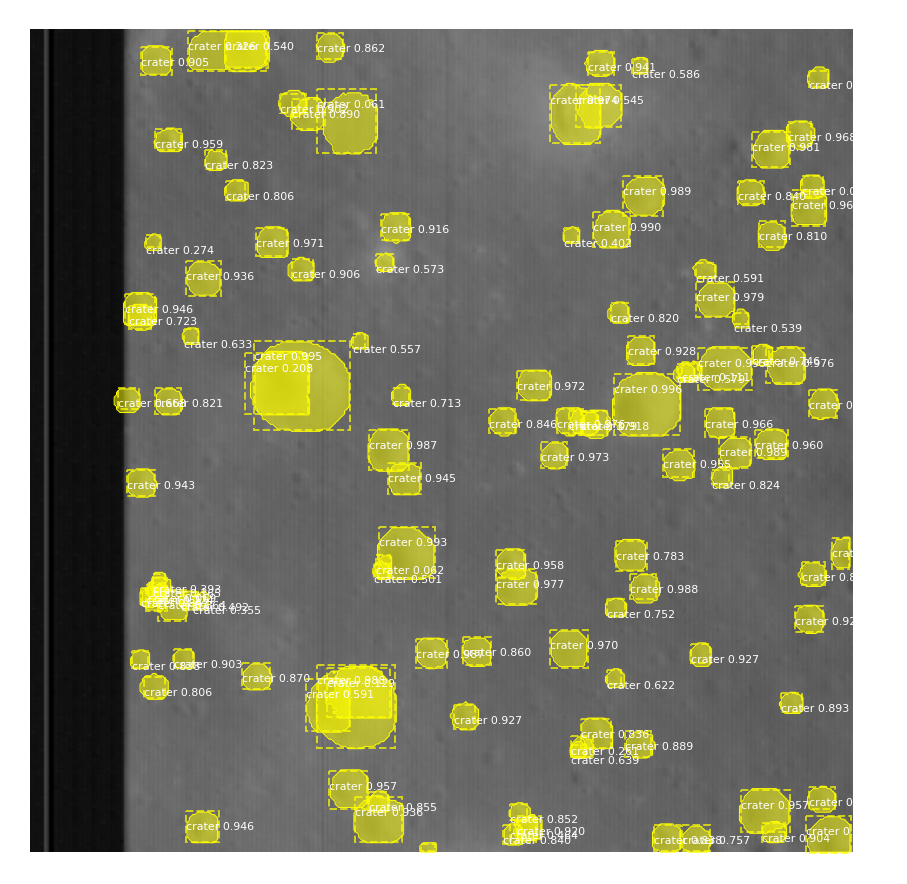

In [ ]:
for i, data in enumerate(dataset_test):
    #print(i)
    image, target = data
    print(image.shape)
    pred = mask_rcnn(image.unsqueeze(0).to(device))[0]

    boxes = pred['boxes'].to("cpu").detach().numpy()
    labels = pred['labels'].to("cpu").detach().numpy()
    scores = pred['scores'].to("cpu").detach().numpy()
    masks = pred['masks'].to("cpu").detach().numpy()  # the predictions, numpy ndarray
    image_name = target['image_name']

    result = {}
    result['bb'] = boxes
    result['labels'] = labels
    result['scores'] = scores
    result['mask'] = masks
    result['image_name'] = image_name
    print(image_name)
    # visualize_gt(image, target)
    # visualize_result(mask_rcnn, data)
    visualize_pred(image, pred)
    break


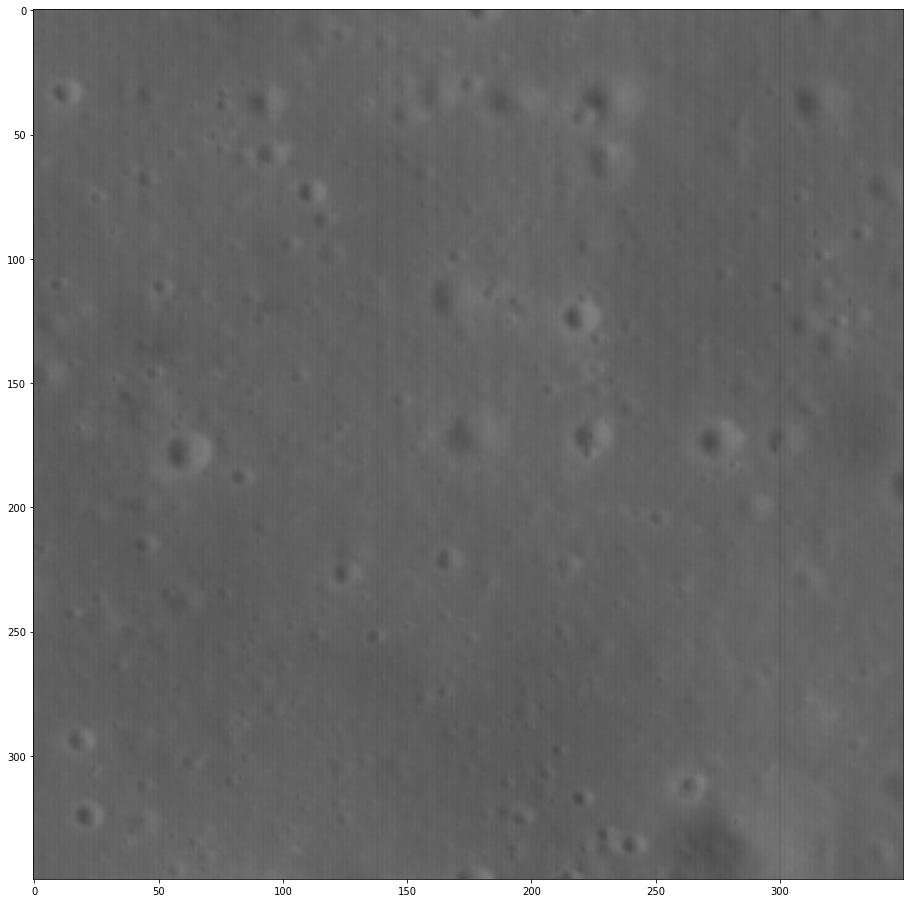

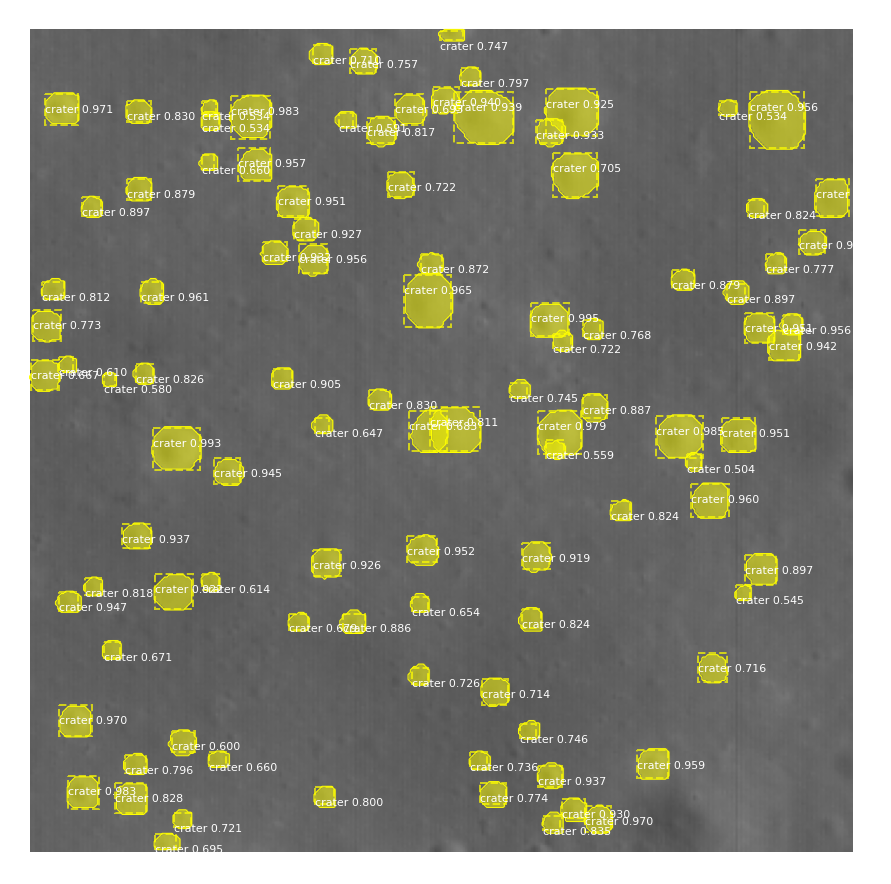

array([[[100, 100, 100],
        [100, 100, 100],
        [ 97,  97,  97],
        ...,
        [ 97,  97,  97],
        [ 98,  98,  98],
        [101, 101, 101]],

       [[101, 101, 101],
        [100, 100, 100],
        [ 96,  96,  96],
        ...,
        [101, 101, 101],
        [ 97,  97,  97],
        [104, 104, 104]],

       [[101, 101, 101],
        [101, 101, 101],
        [ 96,  96,  96],
        ...,
        [100, 100, 100],
        [ 96,  96,  96],
        [ 98,  98,  98]],

       ...,

       [[ 99,  99,  99],
        [101, 101, 101],
        [ 95,  95,  95],
        ...,
        [101, 101, 101],
        [100, 100, 100],
        [102, 102, 102]],

       [[ 99,  99,  99],
        [101, 101, 101],
        [ 96,  96,  96],
        ...,
        [100, 100, 100],
        [ 98,  98,  98],
        [101, 101, 101]],

       [[ 98,  98,  98],
        [101, 101, 101],
        [ 96,  96,  96],
        ...,
        [ 96,  96,  96],
        [ 96,  96,  96],
        [ 99,  99,  99]]

In [ ]:
from PIL import Image
from visualize import display_instances


img_path = '/content/tile_4200_46200.png'
image = Image.open(img_path).convert("RGB")

image = np.array(image)

_, ax = plt.subplots(1, figsize=(16,16))
ax.imshow(image.astype(np.uint8))

image = torch.from_numpy(image / 255.0).float()
image = image.permute((2, 0, 1))





pred = mask_rcnn(image.unsqueeze(0).to(device))[0]
boxes = pred['boxes'].to("cpu").detach().numpy()
labels = pred['labels'].to("cpu").detach().numpy()
scores = pred['scores'].to("cpu").detach().numpy()
masks = pred['masks'].to("cpu").detach().numpy()  # the predictions, numpy ndarray
image_name = target['image_name']


boxes_ = pred["boxes"].cpu().detach().numpy().astype(int)
boxes = np.empty_like(boxes_)
boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3] = boxes_[:, 1], boxes_[:, 0], boxes_[:, 3], boxes_[:, 2]
labels = pred["labels"].cpu().detach().numpy()
scores = pred["scores"].cpu().detach().numpy()
masks = pred["masks"]
indices = scores > 0.5
boxes = boxes[indices]
labels = labels[indices]
scores = scores[indices]
masks = masks[indices].squeeze(1)
masks = (masks.permute((1, 2, 0)).cpu().detach().numpy() > 0.5).astype(np.uint8)
image = image.permute((1, 2, 0)).cpu().detach().numpy()*255
display_instances(image, boxes, masks, labels, class_names=["background", "crater"], scores=scores)


In [ ]:
! sudo add-apt-repository ppa:ubuntugis/ppa -y && apt-get update
! sudo apt-get install gdal-bin libgdal-dev
! export CPLUS_INCLUDE_PATH=/usr/include/gdal
! export C_INCLUDE_PATH=/usr/include/gdal
! pip install GDAL rasterio

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1,750 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,354 kB]
Get:12 https://cloud.r-project